# Multiclass multi-label using the Reuters dataset


This notebook shows how to implement document classification when each document can have multiple categories.

The dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/). 
The topics to be predicted can be found in all-topics-strings.lc.txt. 
I'm adhering to the variable 'lewissplit' to define the Train/Test split. 

To convert the data from sgm to json, I'm drawing on convert_sgm_to_json.py by [mihaibogdan10](https://github.com/mihaibogdan10/json-reuters-21578).

I find the best model to predict topics is the linear support vector classifier, which gets an average F1 score of 51% accross 65 predicted labels, about 5% better than other models. Using a combined text column (original "body" + "title" + "unknown_processed") also improves the model performance by 6%.  

In [1]:
import gzip
import collections
import matplotlib as plt
%matplotlib inline
from os import listdir
import pandas as pd
import numpy as np
import json
import nltk
import itertools
import re
from time import time
from pandas.io.json import json_normalize
from utils import *

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report

# import english stopwords
stop_words = set(stopwords.words('english'))

# EDA

In [2]:
path = '/Users/twenzel/repos/topics2/json-data/'
files = listdir(path)

docs = [open_file(x, path) for x in files]
docs = list(itertools.chain(*docs))
docs_df = pd.DataFrame(docs)
docs_df['topic_length'] = docs_df.topics.apply(len)

# clean column "unknown" - as it helps classifying topics when document body is empty
docs_df['unknown_processed'] = docs_df.unknown.apply(lambda x: x.split('BC-')[-1]).apply(lambda x: x.split('  ')[0])

In [3]:
# analyse the category usage
docs_df.head()

,attrs,body,companies,date,dateline,exchanges,orgs,places,title,topics,unknown,topic_length,unknown_processed
0,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",The Bank of England said it forecast a\nshorta...,[],9-MAR-1987 04:58:41.12,"LONDON, March 9 -",[],[],[uk],U.K. MONEY MARKET SHORTAGE FORECAST AT 250 MLN...,[money-fx],&#5;&#5;&#5;RM\n&#22;&#22;&#1;f0416&#31;reute\...,1,U.K.-MONEY-MARKET-SHO
1,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",The Bank of France said it invited offers\nof ...,[],9-MAR-1987 05:03:09.75,"PARIS, March 9 -",[],[],[france],BANK OF FRANCE SETS MONEY MARKET TENDER,"[money-fx, interest]",&#5;&#5;&#5;RM\n&#22;&#22;&#1;f0423&#31;reute\...,2,BANK-OF-FRANCE-SETS-M
2,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",The U.S. &lt;Amoco Petroleum Corp> has\nreport...,[],9-MAR-1987 05:03:38.51,"PEKING, March 9 -",[],[],[china],AMOCO REPORTS SOUTH CHINA SEA OIL FIND,[crude],&#5;&#5;&#5;F\n&#22;&#22;&#1;f0426&#31;reute\n...,1,AMOCO-REPORTS-SOUTH-C
3,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",Technology transfer problems have delayed\nthe...,[],9-MAR-1987 05:12:17.12,"SEOUL, March 9 -",[],[],[south-korea],SOUTH KOREA DELAYS CONTRACT FOR NUCLEAR PLANTS,[],&#5;&#5;&#5;F\n&#22;&#22;&#1;f0437&#31;reute\n...,0,SOUTH-KOREA-DELAYS-CO
4,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",Keiaisha Co Ltd of Tokyo is issuing 12\nmln Sw...,[],9-MAR-1987 05:19:27.56,"ZURICH, March 9 -",[],[],[switzerland],KEIAISHA ISSUING 12 MLN SWISS FRANC NOTES,[],&#5;&#5;&#5;RM\n&#22;&#22;&#1;f0442&#31;reute\...,0,KEIAISHA-ISSUING-12-M


In [4]:
# Look at unique topics
topic_path = '/Users/twenzel/repos/topics2/other-data/all-topics-strings.lc.txt'
topics = pd.read_csv(topic_path).acq.tolist()
print(topics)

['alum', 'austdlr', 'austral', 'barley', 'bfr', 'bop', 'can', 'carcass', 'castor-meal', 'castor-oil', 'castorseed', 'citruspulp', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'corn-oil', 'cornglutenfeed', 'cotton ', 'cotton-meal', 'cotton-oil', 'cottonseed', 'cpi', 'cpu', 'crude', 'cruzado', 'dfl', 'dkr', 'dlr', 'dmk', 'drachma', 'earn', 'escudo', 'f-cattle', 'ffr', 'fishmeal', 'flaxseed', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-meal', 'groundnut-oil', 'heat', 'hk', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'inventories', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-meal', 'lin-oil', 'linseed', 'lit', 'livestock', 'lumber', 'lupin', 'meal-feed', 'mexpeso', 'money-fx', 'money-supply', 'naphtha     ', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-meal', 'palm-oil', 'palmkernel', 'peseta', 'pet-chem', 'platinum', 'plywood', 'pork-belly', 'potato', 'propane', 'ra

In [5]:
# Count frequency of topics used
cats_combo = list(itertools.chain(*docs_df.topics.tolist()))
counter=collections.Counter(cats_combo)
print(counter.most_common)

<bound method Counter.most_common of Counter({'earn': 3987, 'acq': 2448, 'money-fx': 801, 'crude': 634, 'grain': 628, 'trade': 552, 'interest': 513, 'wheat': 306, 'ship': 305, 'corn': 254, 'dlr': 217, 'oilseed': 192, 'money-supply': 190, 'sugar': 184, 'gnp': 163, 'coffee': 145, 'veg-oil': 137, 'gold': 135, 'nat-gas': 130, 'soybean': 120, 'bop': 116, 'livestock': 114, 'cpi': 112, 'reserves': 84, 'copper': 78, 'jobs': 76, 'cocoa': 76, 'carcass': 75, 'yen': 69, 'rice': 67, 'iron-steel': 67, 'gas': 65, 'ipi': 65, 'alum': 63, 'cotton': 63, 'barley': 54, 'meal-feed': 51, 'rubber': 51, 'zinc': 44, 'palm-oil': 43, 'pet-chem': 41, 'silver': 37, 'rapeseed': 35, 'lead': 35, 'sorghum': 35, 'tin': 33, 'strategic-metal': 32, 'wpi': 32, 'orange': 29, 'fuel': 28, 'hog': 27, 'soy-meal': 27, 'retail': 27, 'heat': 25, 'soy-oil': 25, 'housing': 21, 'stg': 21, 'income': 18, 'lei': 17, 'lumber': 17, 'sunseed': 17, 'dmk': 15, 'tea': 15, 'oat': 14, 'platinum': 12, 'nickel': 11, 'groundnut': 10, 'l-cattle': 9,

We see a lot of topics appear only ones. In the training, we will need to subset on the topics that appear at least a few times in the training set. More observations for these topics has to be collected to make meaningful predictions for these cases.

# Labels 

What are the most common labels?

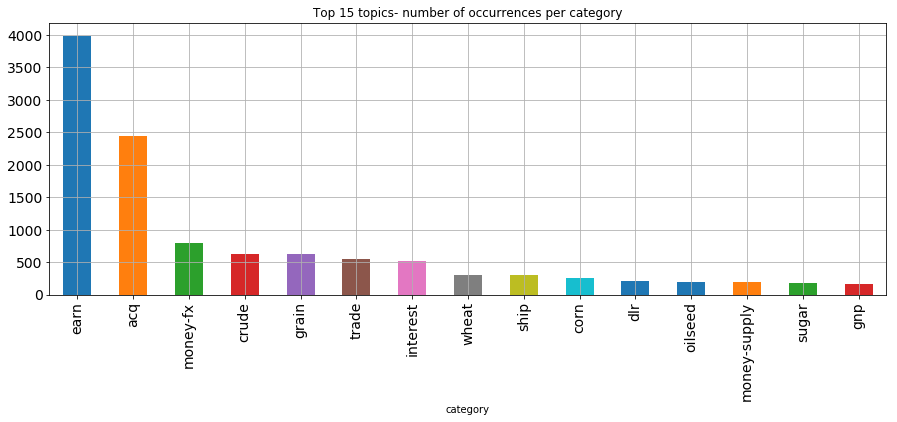

In [6]:
# plot topic frequencies
cat_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
cat_df.columns=['category', 'number_of_occurrences']
cat_df.sort_values(by = ['number_of_occurrences'], ascending=False, inplace=True)

cat_df.head(15).plot(x='category', 
                     y='number_of_occurrences', 
                     kind='bar', 
                     legend=False, 
                     grid=True, 
                     figsize=(15, 5), 
                     fontsize = 14,
                     title="Top 15 topics- number of occurrences per category")

In [7]:
# from sklearn.preprocessing import MultiLabelBinarizer
# label_matrix = MultiLabelBinarizer().fit_transform(docs_df.topics)

# Multilabel 

How many articles have several labels?

47% of documents are not labelled.


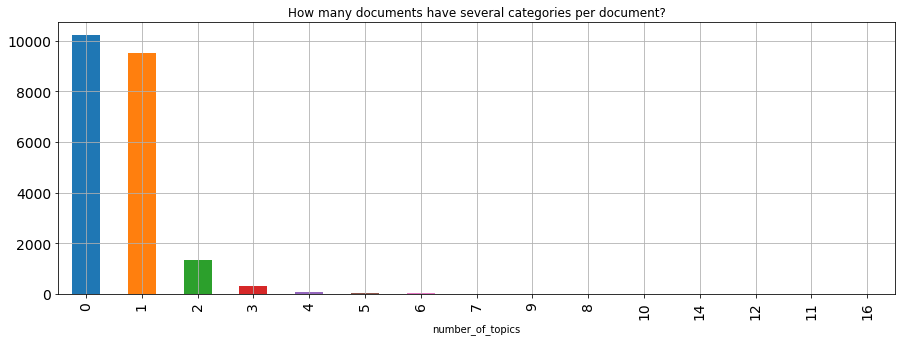

In [8]:
label_count_df = docs_df.topic_length.value_counts().reset_index()
label_count_df.columns = ['number_of_topics','number_of_occurrences']

label_count_df.plot(x='number_of_topics', 
                     y='number_of_occurrences', 
                     kind='bar', 
                     legend=False, 
                     grid=True, 
                     figsize=(15, 5), 
                     fontsize = 14,
                     title="How many documents have several categories per document?")
print('{:.2g}% of documents are not labelled.'.format(100*(docs_df[docs_df.topic_length==0].shape[0]/docs_df.shape[0])))

In [9]:
# Create dummies for each label - binary matrix over multiple labels
cat_df = pd.get_dummies(docs_df.topics.apply(pd.Series).stack()).sum(level=0)
# replace all 2s with 1
cat_df.replace(to_replace=2, value=1, inplace=True)
# combine 
docs_df = pd.concat([docs_df, cat_df], axis=1, join_axes=[docs_df.index]).fillna(0)

# Create attributes df
attr = pd.DataFrame()
for n in range(len(docs)):
    attr = attr.append(json_normalize(docs[n]['attrs']))
attr = attr.reset_index().drop('index',axis=1)
attr.drop('topics',axis=1, inplace=True)

# combine dfs
docs_df = pd.concat([docs_df, attr], axis=1, join_axes=[docs_df.index]).fillna(0)

# Length of documents

Number of missing comments in comment text:{} 0
Most documents contain less than 508 characters. The longest document contains 13400 characters.


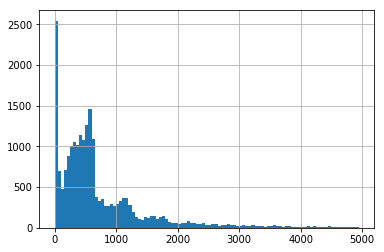

In [25]:
lens = docs_df.body.str.len()

print('Number of missing comments in comment text:{}',format(docs_df['body'].isnull().sum()))

lens.hist(bins = np.arange(0,5000,50))
print('Most documents contain less than {} characters. The longest document contains {} characters.'
      .format(int(docs_df.body.str.len().median()),
              int(docs_df.body.str.len().max()))
     )

In [26]:
'We also see a large number of documents w/o any text: {}'.format(docs_df[docs_df.body.str.len()==0].shape[0])

'We also see a large number of documents w/o any text: 2535'

In [27]:
print('They are still allocated to training & test group as the below shows:')
docs_df[docs_df.body.str.len()==0].lewissplit.value_counts()

They are still allocated to training & test group as the below shows:


TRAIN       1803
TEST         730
NOT-USED       2
Name: lewissplit, dtype: int64

In [28]:
print('If the body is missing, the title and unknown field can be used to predict labels.')
docs_df[docs_df.body.str.len()==0][['title','unknown_processed','topics']].head()

If the body is missing, the title and unknown field can be used to predict labels.


,title,unknown_processed,topics
5,NATIONAL WESTMINSTER BANK SAYS IT CUTTING BASE...,NATIONAL-WESTMINSTER,[interest]
34,Chrysler to take over Renault stake in America...,Chrysler-to-take-over,[acq]
36,SOUTHERN CO TO TAKE 226 MLN DLR CHARGE ON PROJ...,******southern-co-to,[earn]
40,GENCORP TO SELL LOS ANGELES TELEVISION STATION...,******GENCORP-TO-SELL,[acq]
48,FRENCH JAN M-3 MONEY SUPPLY ROSE PROV ADJUSTED...,FRENCH-JAN-M-3-MONEY,[money-supply]


In [29]:
# 1 document is w/o body, title and unknown field. We will exclude it from Training.
docs_df[(docs_df.body.str.len()==0) & (docs_df.title.str.len()==0) & (docs_df.unknown_processed.str.len()==0)][['newid','unknown_processed','title','body','topics','lewissplit' ]]

,newid,unknown_processed,title,body,topics,lewissplit
9792,12793,,,,[],TRAIN


In [10]:
docs_df['body'] = docs_df.body.apply(lambda x: clean_text(x))
docs_df['unknown_processed'] = docs_df.unknown_processed.apply(lambda x: clean_text(x))
docs_df['unknown_processed'].head()

# Create additional text variable containing body, title & unknown_processed combined. This should help classifying documents where one of the fields, e.g. body is missing.
docs_df['txt_combined'] = docs_df['body'] + ' ' + docs_df['title'] + ' ' + docs_df['unknown_processed']

In [11]:
docs_df[['newid','unknown_processed','title','body','topics','txt_combined','lewissplit' ]].tail()

,newid,unknown_processed,title,body,topics,txt_combined,lewissplit
21573,16996,state of n j in m,STATE OF N.J. IN 43 MLN DLR PROGRAM STOCK SALE,the state of new jersey said that it sold st...,[],the state of new jersey said that it sold st...,NOT-USED
21574,16997,du pont lt dd conoco,DU PONT'S &lt;DD> CONOCO FINDS OIL OFFSHORE CONGO,du pont co conoco inc said the viodo marine nu...,[crude],du pont co conoco inc said the viodo marine nu...,NOT-USED
21575,16998,falconbridge lt falcf o,FALCONBRIDGE &lt;FALCF.O> SEES IMPROVED RESULTS,falconbridge ltd said it expected results for ...,"[nickel, acq]",falconbridge ltd said it expected results for ...,NOT-USED
21576,16999,symbol technologies lt,SYMBOL TECHNOLOGIES &lt;SMBL.O> FILES SHARE OFFER,symbol technologies inc said it filed with the...,[],symbol technologies inc said it filed with the...,NOT-USED
21577,17000,transcanada lt trp den,TRANSCANADA &lt;TRP> DENIES REPORTS OF NEW BID,transcanada pipelines ltd denied reports that ...,[acq],transcanada pipelines ltd denied reports that ...,NOT-USED


# Train test split

In [12]:
X_train = docs_df[(docs_df.lewissplit=='TRAIN') & (docs_df.newid !=12793)]
X_test = docs_df[(docs_df.lewissplit=='TEST')].drop('topics', axis=1)

# categories to predict - subset on categories that appear more than twice in the training & test set
cat_obs_count_train = X_train[cat_df.columns.tolist()].sum()>5
categories_with_enough_obs_train = cat_obs_count_train[cat_obs_count_train.values].index.tolist()

cat_obs_count_test = X_test[cat_df.columns.tolist()].sum()>5
categories_with_enough_obs_test = cat_obs_count_test[cat_obs_count_test.values].index.tolist()


categories_with_enough_observations = list(set(categories_with_enough_obs_train).intersection(set(categories_with_enough_obs_test)))
print('Some topics only occur once or twice. To ensures that we can calculate model performance metrics, we will use only {}/120 topics for prediction.  (In practice, a much higher threshold should be set, e.g. 20 times to train a classifier for a label.)'.format(len(categories_with_enough_observations)))
# categories_with_enough_observations = dict((k, v) for k, v in counter.items() if v > 1)
# categories_with_enough_observations = list(categories_with_enough_observations.keys())

# t = json_normalize(counter)
# t[t>1].dropna(axis=1).columns.tolist()

Some topics only occur once or twice. To ensures that we can calculate model performance metrics, we will use only 56/120 topics for prediction.  (In practice, a much higher threshold should be set, e.g. 20 times to train a classifier for a label.)


# Train classifier

Next we train a classifier that fits our problem. We have multiple classes (120 topics) amd each document can belong to multiple classes (up to 16) at the same time. A multi-class multi-label classifier is appropriate in such situations and can be implemented in scikit-learn. 

### OneVsRest multi-label strategy
The OneVsRest strategy can be used for multi-label learning, where a classifier is used to predict multiple labels for each input. This classifier accepts a binary mask over multiple labels. We constructed this in cat_df. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

### Linear classifiers
The next step identifies several linear classifiers: Multi-class version of Naive Bayes (MultinomialNB), stochastic gradient descent (SGDClassifier), Support Vector (LinearSVC), Stochastic gradient descent (SGDClassifier).

### Non-linear classifiers
To allow for more complex relationship modeling, I compare the linear classifiers to a multi-layer perceptron (MLP) classifier. 

### Pipeline
In order to make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class that behaves like a compound classifier. 

The text is passed into a processing step (TfidfVectorizer), which converts a collection of raw documents to a matrix of TF-IDF features. This step counts the term frequencies in the text and scales down terms that occur very frequently in the corpus of documents. Hence, less informative terms have lower values. 

### Model performance metrics
I chose F1 score as evaluation metric to optimise, since it is more robust to imbalanced classes than, e.g. the accuracy score. Using the accuracy score, it is easy to get a score around 99% by simply predicting the majority class, which is zero. 

There are other options: 
- Converting the labels to numbers, one could predict multiple labels from the predictions as output and use the recommended F1 scoring method 'f1_samples' in the GridSearch step.
- The recommended scoring metric in the literature for multi-class multi-label problems is Hamming loss (how many classes per example were correct?) and 0-1 loss (for how many examples were all classes correct)


# Tuning
I use randomized search, which search the parameter space more efficiently than exhaustive GridSearch.

### Possible extensions
- Ensemble: train several classifiers on other non-text variables and combine predictions of text and non-text models. For example, performance can be improved by training 1 classifier using text, another using the non-text information in the documents and then combining the 2 classifiers in an ensemble. 
- Keras implementations to scale on bigger dataset, e.g. [Reuters dataset](https://github.com/philipperemy/Reuters-full-data-set)
- Explore bigger parameter space
- Feature engineering: e.g. word embedding layers for deep learning with Keras, Word2Vec, GloVe
- Rerun models on full Reuters dataset 
- make graphs of performance metrics
- Try optimise other evaluation metrics for multi-label classification: Hamming loss and 0-1 loss

# LinearSVC

In [13]:
# silence some warnings (version incompatibilities btw. h5py and numpy)
import warnings
warnings.simplefilter('ignore')

In [14]:
SVC_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC())),
            ])
svc_scores = {}
for category in categories_with_enough_observations:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    SVC_clf.fit(X_train.body, X_train[category])
    # compute the testing F1 score
    prediction = SVC_clf.predict(X_test.body)
    f1_value = f1_score(X_test[category], prediction)
    svc_scores[category] = f1_value
    print('Test F1 score is {}'.format(f1_value))

... Processing oilseed
Test F1 score is 0.5714285714285714
... Processing reserves
Test F1 score is 0.6153846153846153
... Processing gold
Test F1 score is 0.41860465116279066
... Processing wpi
Test F1 score is 0.5714285714285715
... Processing cocoa
Test F1 score is 0.6666666666666666
... Processing acq
Test F1 score is 0.754047802621434
... Processing ship
Test F1 score is 0.6222222222222222
... Processing soy-meal
Test F1 score is 0.14285714285714288
... Processing meal-feed
Test F1 score is 0.2727272727272727
... Processing strategic-metal
Test F1 score is 0.0
... Processing yen
Test F1 score is 0.0
... Processing wheat
Test F1 score is 0.7438016528925621
... Processing cpi
Test F1 score is 0.3888888888888889
... Processing rapeseed
Test F1 score is 0.6153846153846153
... Processing silver
Test F1 score is 0.0
... Processing bop
Test F1 score is 0.5454545454545455
... Processing cotton
Test F1 score is 0.6666666666666666
... Processing income
Test F1 score is 0.0
... Processing ho

In [15]:
SVC_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', LinearSVC()),
            ])
svc_scores2 = {}
for category in categories_with_enough_observations:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    SVC_clf.fit(X_train.txt_combined, X_train[category])
    # compute the testing F1 score
    prediction = SVC_clf.predict(X_test.txt_combined)
    f1_value = f1_score(X_test[category], prediction)
    svc_scores2[category] = f1_value
    print('Test F1 score is {}'.format(f1_value))

... Processing oilseed
Test F1 score is 0.5675675675675675
... Processing reserves
Test F1 score is 0.6896551724137931
... Processing gold
Test F1 score is 0.5531914893617021
... Processing wpi
Test F1 score is 0.8235294117647058
... Processing cocoa
Test F1 score is 0.75
... Processing acq
Test F1 score is 0.8237015362106802
... Processing ship
Test F1 score is 0.6330935251798561
... Processing soy-meal
Test F1 score is 0.14285714285714288
... Processing meal-feed
Test F1 score is 0.2727272727272727
... Processing strategic-metal
Test F1 score is 0.0
... Processing yen
Test F1 score is 0.0
... Processing wheat
Test F1 score is 0.8031496062992126
... Processing cpi
Test F1 score is 0.5128205128205129
... Processing rapeseed
Test F1 score is 0.6153846153846153
... Processing silver
Test F1 score is 0.0
... Processing bop
Test F1 score is 0.68
... Processing cotton
Test F1 score is 0.5714285714285715
... Processing income
Test F1 score is 0.4444444444444445
... Processing hog
Test F1 sco

In [92]:
# Comparing the performance btw.'body' and 'txt_combined'
diff = {x: svc_scores2[x] - svc_scores[x] for x in svc_scores2 if x in svc_scores}
print('Using the combined text variable "txt_combined" instead of "body", improves the F1 score by {:.2g}% on average'.format(100*(sum(diff.values())/len(diff))))

Using the combined text variable "txt_combined" instead of "body", improves the F1 score by 5.5% on average


In [114]:
# Print largest coefficients
vec, clf = SVC_clf.named_steps['tfidf'], SVC_clf.named_steps['clf']
coefs = pd.Series(clf.coef_[0], index=vec.get_feature_names())
print("\n20 most discriminating words:")
print(coefs[coefs.abs().sort_values(ascending=False).index][:20])


20 most discriminating words:
shipping        2.631469
ships           2.341930
vessels         2.072995
port            1.945230
vessel          1.706659
mt              1.581577
seamen          1.579861
cargo           1.427407
ship            1.311303
canal           1.301302
sea             1.231398
freight         1.214308
tankers         1.202379
dwt             1.171242
transport       1.162541
harbour         1.116598
river           1.090166
tanker          1.048441
warships        1.048380
shipbuilding    0.948403
dtype: float64


# Stochastic gradient descent 

In [102]:
SGD_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(SGDClassifier())),
            ])
sgd_scores = {}
for category in categories_with_enough_observations:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    SGD_clf.fit(X_train.body, X_train[category])
    # compute the testing F1 score
    prediction = SGD_clf.predict(X_test.body)
    f1_value = f1_score(X_test[category], prediction)
    sgd_scores[category] = f1_value
    print('Test F1 score is {}'.format(f1_value))

... Processing trade
Test F1 score is 0.6078431372549019
... Processing carcass
Test F1 score is 0.19999999999999998
... Processing silver
Test F1 score is 0.0
... Processing money-supply
Test F1 score is 0.4782608695652174
... Processing reserves
Test F1 score is 0.4347826086956522
... Processing palm-oil
Test F1 score is 0.5714285714285715
... Processing lumber
Test F1 score is 0.0
... Processing sorghum
Test F1 score is 0.18181818181818182
... Processing sugar
Test F1 score is 0.8064516129032258
... Processing soy-oil
Test F1 score is 0.0
... Processing ipi
Test F1 score is 0.2857142857142857
... Processing money-fx
Test F1 score is 0.5201465201465201
... Processing rice
Test F1 score is 0.27586206896551724
... Processing coffee
Test F1 score is 0.9056603773584904
... Processing cpi
Test F1 score is 0.35294117647058826
... Processing orange
Test F1 score is 0.42857142857142855
... Processing iron-steel
Test F1 score is 0.23529411764705882
... Processing soybean
Test F1 score is 0.26

In [103]:
# Comparing SVC vs. SGD model performance 
diff = {x: svc_scores2[x] - sgd_scores[x] for x in svc_scores2 if x in sgd_scores}
print('Using a default SVC instead of SGD classifier improves the F1 score by {:.2g}% on average'.format(100*(sum(diff.values())/len(diff))))

Using a default SVC instead of SGD classifier improves the F1 score by 14% on average


Hence the best default model remains the Support vector classifier. 

# MultinomialNB

We notice that the multinomial version of naive Bayes does not predict any positive classes. Hence F1 score is always 0. 

In [93]:
# precision = TP/(TP+FP) as you've just said if predictor doesn't predicts positive class at all - precision is 0.
# recall = TP/(TP+FN), in case if predictor doesn't predict positive class - TP is 0 - recall is 0.
# So now you are dividing 0/0.

NB_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories_with_enough_observations:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    NB_clf.fit(X_train.txt_combined, X_train[category])
    # compute the testing F1 score
    prediction = NB_clf.predict(X_test.txt_combined)
    print('Test F1 score is {}'.format(f1_score(X_test[category], prediction)))

... Processing trade
Test F1 score is 0.0
... Processing carcass
Test F1 score is 0.0
... Processing silver
Test F1 score is 0.0
... Processing money-supply
Test F1 score is 0.0
... Processing reserves
Test F1 score is 0.0
... Processing palm-oil
Test F1 score is 0.0
... Processing lumber
Test F1 score is 0.0
... Processing sorghum
Test F1 score is 0.0
... Processing sugar
Test F1 score is 0.0
... Processing soy-oil
Test F1 score is 0.0
... Processing ipi
Test F1 score is 0.0
... Processing money-fx
Test F1 score is 0.0
... Processing rice
Test F1 score is 0.0
... Processing coffee
Test F1 score is 0.0
... Processing cpi
Test F1 score is 0.0
... Processing orange
Test F1 score is 0.0
... Processing iron-steel
Test F1 score is 0.0
... Processing soybean
Test F1 score is 0.0
... Processing yen
Test F1 score is 0.0
... Processing corn
Test F1 score is 0.0
... Processing rubber
Test F1 score is 0.0
... Processing gnp
Test F1 score is 0.0
... Processing strategic-metal
Test F1 score is 0.0


# Logistic Regression

In [97]:
LR_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories_with_enough_observations:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    LR_clf.fit(X_train.txt_combined, X_train[category])
    # compute the testing F1 score
    prediction = LR_clf.predict(X_test.txt_combined)
    print('Test F1 score is {}'.format(f1_score(X_test[category], prediction)))

... Processing trade
Test F1 score is 0.5775401069518716
... Processing carcass
Test F1 score is 0.10526315789473684
... Processing silver
Test F1 score is 0.0
... Processing money-supply
Test F1 score is 0.40909090909090906
... Processing reserves
Test F1 score is 0.19999999999999998
... Processing palm-oil
Test F1 score is 0.0
... Processing lumber
Test F1 score is 0.0
... Processing sorghum
Test F1 score is 0.0
... Processing sugar
Test F1 score is 0.4347826086956522
... Processing soy-oil
Test F1 score is 0.0
... Processing ipi
Test F1 score is 0.0
... Processing money-fx
Test F1 score is 0.46031746031746035
... Processing rice
Test F1 score is 0.0
... Processing coffee
Test F1 score is 0.6
... Processing cpi
Test F1 score is 0.25
... Processing orange
Test F1 score is 0.0
... Processing iron-steel
Test F1 score is 0.0
... Processing soybean
Test F1 score is 0.0
... Processing yen
Test F1 score is 0.0
... Processing corn
Test F1 score is 0.49350649350649356
... Processing rubber
Te

# MLPClassifier

In [100]:
MLP_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MLPClassifier(solver='lbfgs'
#                                                           alpha=1e-5,
#                                                           hidden_layer_sizes=(5, 2)
                                                         )
                                            , n_jobs=1)),
            ])
mlp_scores = {}

for category in categories_with_enough_observations:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    MLP_clf.fit(X_train.txt_combined, X_train[category])
    # compute the testing F1 score
    prediction = MLP_clf.predict(X_test.txt_combined)
    f1_value = f1_score(X_test[category], prediction)
    mlp_scores[category] = f1_value
    print('Test F1 score is {}'.format(f1_value))

... Processing trade
Test F1 score is 0.6861924686192469
... Processing carcass
Test F1 score is 0.5
... Processing silver
Test F1 score is 0.2222222222222222
... Processing money-supply
Test F1 score is 0.6363636363636364
... Processing reserves
Test F1 score is 0.6896551724137931
... Processing palm-oil
Test F1 score is 0.7499999999999999
... Processing lumber
Test F1 score is 0.0
... Processing sorghum
Test F1 score is 0.4
... Processing sugar
Test F1 score is 0.7999999999999999
... Processing soy-oil
Test F1 score is 0.14285714285714288
... Processing ipi
Test F1 score is 0.8571428571428571
... Processing money-fx
Test F1 score is 0.5391849529780566
... Processing rice
Test F1 score is 0.5882352941176471
... Processing coffee
Test F1 score is 0.9433962264150945
... Processing cpi
Test F1 score is 0.48780487804878053
... Processing orange
Test F1 score is 0.8571428571428572
... Processing iron-steel
Test F1 score is 0.5833333333333334
... Processing soybean
Test F1 score is 0.555555

In [101]:
# Comparing MPL performance vs. SVC classifier
diff = {x: svc_scores2[x] - mlp_scores[x] for x in svc_scores2 if x in mlp_scores}
print('Using MLP instead of SVC improves the F1 score by {:.2g}% on average'.format(100*(sum(diff.values())/len(diff))))

Using MLP instead of SVC improves the F1 score by -3.7% on average


Hence the best default model remains the Support vector classifier. 

# Tuning

Let's see if we can improve evaluation metrics by optimising hyper-parameters using GridSearch. 

In [138]:
# Define a pipeline combining a text feature extractor with multi label classifier
SGD_clf = Pipeline([
    ('vect', TfidfVectorizer(stop_words = stop_words)),
    ('clf', SGDClassifier()),
])

sgd_grid_results = {}

parameters = {
    'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'vect__use_idf': (True, False),
    'clf__alpha': (0.00001, 0.000001),
}

random_search = RandomizedSearchCV(SGD_clf, parameters, n_jobs=4, n_iter=20, verbose=1, scoring='f1')
# scoring = If None, the estimator’s default scorer is used (usually accuracy).

for category in categories_with_enough_observations:
    print("{}: Performing grid search ...".format(category))
    print("pipeline:", [name for name, _ in SGD_clf.steps])
    print("parameters:")
    print(parameters)
    start = time()
    random_search.fit(X_train.txt_combined.tolist(), X_train[category])
    print("done in {:0.3f}s".format(time() - start))
    print()
    print("Best score: {:0.3f}".format(random_search.best_score_))
    params = {}
    print("Best parameters set:")
    best_parameters = random_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        params[param_name] = best_parameters[param_name]
        print("\t{}: {}".format(param_name, best_parameters[param_name]))
    sgd_grid_results[category] = [random_search.best_score_,params]

trade: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 186.229s

Best score: 0.747
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: False
carcass: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.4min finished


done in 205.349s

Best score: 0.631
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
silver: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.1min finished


done in 191.374s

Best score: 0.250
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: False
money-supply: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.1min finished


done in 194.166s

Best score: 0.824
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: True
reserves: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.3min finished


done in 202.561s

Best score: 0.823
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: True
palm-oil: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.3min finished


done in 197.219s

Best score: 0.668
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
lumber: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 163.214s

Best score: 0.244
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
sorghum: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 149.696s

Best score: 0.512
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: True
sugar: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


done in 199.594s

Best score: 0.856
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
soy-oil: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 154.253s

Best score: 0.239
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: False
ipi: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 159.933s

Best score: 0.784
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: False
money-fx: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


done in 191.166s

Best score: 0.763
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: False
rice: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.1min finished


done in 189.931s

Best score: 0.680
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: True
coffee: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


done in 203.587s

Best score: 0.862
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
cpi: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


done in 200.967s

Best score: 0.694
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
orange: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 165.693s

Best score: 0.753
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
iron-steel: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.3min finished


done in 199.518s

Best score: 0.572
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: True
soybean: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.8min finished


done in 296.019s

Best score: 0.615
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: False
yen: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.3min finished


done in 325.532s

Best score: 0.347
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: False
corn: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


done in 208.917s

Best score: 0.790
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
rubber: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.4min finished


done in 271.671s

Best score: 0.719
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: False
gnp: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.3min finished


done in 206.577s

Best score: 0.769
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: True
strategic-metal: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.1min finished


done in 190.039s

Best score: 0.500
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
acq: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.1min finished


done in 194.666s

Best score: 0.841
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: False
interest: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


done in 197.739s

Best score: 0.707
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: False
alum: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 180.239s

Best score: 0.775
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
	vect__use_idf: True
tin: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.5min finished


done in 211.413s

Best score: 0.833
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: False
grain: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


done in 196.702s

Best score: 0.843
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: True
barley: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 182.998s

Best score: 0.679
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: False
soy-meal: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


done in 193.748s

Best score: 0.194
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: False
lead: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 176.138s

Best score: 0.411
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: False
zinc: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 154.159s

Best score: 0.777
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: True
jobs: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


done in 191.344s

Best score: 0.867
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: False
gold: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 177.851s

Best score: 0.771
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: True
oat: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.4min finished


done in 149.214s

Best score: 0.217
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: True
hog: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.5min finished


done in 214.673s

Best score: 0.437
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: True
gas: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.6min finished


done in 215.733s

Best score: 0.542
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: True
nat-gas: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.3min finished


done in 202.019s

Best score: 0.592
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
	vect__use_idf: True
meal-feed: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.2min finished


done in 194.405s

Best score: 0.347
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: False
livestock: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.4min finished


done in 213.323s

Best score: 0.485
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: True
fuel: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 156.480s

Best score: 0.357
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: True
dlr: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.1min finished


done in 186.262s

Best score: 0.646
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
	vect__use_idf: True
oilseed: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 179.190s

Best score: 0.605
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: True
pet-chem: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 170.637s

Best score: 0.275
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: True
cotton: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 181.456s

Best score: 0.554
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: True
earn: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 163.271s

Best score: 0.946
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
	vect__use_idf: False
income: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 161.463s

Best score: 0.500
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: True
cocoa: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 158.524s

Best score: 0.815
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
bop: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 174.110s

Best score: 0.716
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: False
crude: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 186.881s

Best score: 0.836
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: True
veg-oil: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 155.656s

Best score: 0.754
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: False
wpi: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 162.464s

Best score: 0.867
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: True
copper: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.3min finished


done in 146.404s

Best score: 0.628
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: False
rapeseed: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 169.054s

Best score: 0.656
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
wheat: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.4min finished


done in 151.072s

Best score: 0.796
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: False
ship: Performing grid search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 159.395s

Best score: 0.761
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: True


In [144]:
sgd_grid_results['trade']

[0.7471394521193508,
 {'clf__alpha': 1e-05,
  'vect__max_df': 0.5,
  'vect__ngram_range': (1, 2),
  'vect__use_idf': False}]

In [ ]:
SVC_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(class_weight='auto'))),
            ])

parameters = {
    'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000],
    'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
}

svc_grid_results = {}
random_search = RandomizedSearchCV(SVC_clf, parameters, n_jobs=4, n_iter=15, verbose=1, scoring='f1')

for category in categories_with_enough_observations:
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in SVC_clf.steps])
    print("parameters:")
    print(parameters)
    start = time()
    random_search.fit(X_train.txt_combined.tolist(), X_train[category])
    print("done in {:0.3f}s".format(time() - start))
    print()

    print("Best score: {:0.3f}".format(random_search.best_score_))
    params = {}
    print("Best parameters set:")
    best_parameters = random_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        params[param_name] = best_parameters[param_name]
        print("\t{}: {}".format(param_name, best_parameters[param_name]))
    svc_grid_results[category] = [random_search.best_score_,params]
#     prediction = random_search.predict(X_test.txt_combined)
#     print(prediction)
#     f1_value = f1_score(X_test['trade'], prediction)
#     print(f1_value)


Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.6min finished


done in 161.155s

Best score: 0.593
Best parameters set:
	clf__estimator__C: 0.1
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 148.802s

Best score: 0.837
Best parameters set:
	clf__estimator__C: 1000
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 1)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 143.087s

Best score: 0.730
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 123.987s

Best score: 0.822
Best parameters set:
	clf__estimator__C: 1000
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 133.095s

Best score: 0.788
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.6min finished


done in 169.562s

Best score: 0.837
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  3.5min finished


done in 209.429s

Best score: 0.760
Best parameters set:
	clf__estimator__C: 1
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 1)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 142.686s

Best score: 0.306
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 1)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 142.673s

Best score: 0.408
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 1)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 136.901s

Best score: 0.468
Best parameters set:
	clf__estimator__C: 0.1
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.9min finished


done in 173.348s

Best score: 0.428
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.5min finished


done in 156.399s

Best score: 0.815
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 147.606s

Best score: 0.699
Best parameters set:
	clf__estimator__C: 1000
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 119.530s

Best score: 0.656
Best parameters set:
	clf__estimator__C: 1000
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)
Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [22]:
NB_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

parameters = {
    'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__smooth_idf': (True, False),
}

nb_grid_results = {}
random_search = RandomizedSearchCV(NB_clf, parameters, n_jobs=4, n_iter=15, verbose=1, scoring='f1')

for category in categories_with_enough_observations:
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in NB_clf.steps])
    print("parameters:")
    print(parameters)
    start = time()
    random_search.fit(X_train.txt_combined.tolist(), X_train[category])
    print("done in {:0.3f}s".format(time() - start))
    print()

    print("Best score: {:0.3f}".format(random_search.best_score_))
    params = {}
    print("Best parameters set:")
    best_parameters = random_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        params[param_name] = best_parameters[param_name]
        print("\t{}: {}".format(param_name, best_parameters[param_name]))
    nb_grid_results[category] = [random_search.best_score_,params]


Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x1039d18a0, file "/Lib...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Library/Frameworks/Python.framework/Versions/3....ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Library/Fra.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x1039d18a0, file "/Lib...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Library/Frameworks/Python.framework/Versions/3....ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Library/Fra.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    107         except (RuntimeError, AssertionError):
    108             old_loop = None
    109         try:
    110             self._setup_logging()
    111             asyncio.set_event_loop(self.asyncio_loop)
--> 112             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    113         finally:
    114             asyncio.set_event_loop(old_loop)
    115 
    116     def stop(self):

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    416             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    417                                    finalizer=self._asyncgen_finalizer_hook)
    418         try:
    419             events._set_running_loop(self)
    420             while True:
--> 421                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    422                 if self._stopping:
    423                     break
    424         finally:
    425             self._stopping = False

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1426                         logger.warning('Executing %s took %.3f seconds',
   1427                                        _format_handle(handle), dt)
   1428                 finally:
   1429                     self._current_handle = None
   1430             else:
-> 1431                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(14, 1)>>
   1432         handle = None  # Needed to break cycles when an exception occurs.
   1433 
   1434     def _set_coroutine_wrapper(self, enabled):
   1435         try:

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(14, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (14, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=14, events=1)
     97             self.writers.remove(fd)
     98         del self.handlers[fd]
     99 
    100     def _handle_events(self, fd, events):
    101         fileobj, handler_func = self.handlers[fd]
--> 102         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    103 
    104     def start(self):
    105         try:
    106             old_loop = asyncio.get_event_loop()

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "NB_clf = Pipeline([\n                ('tfidf', Tf....format(param_name, best_parameters[param_name]))", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 17, 15, 15, 4, 529402, tzinfo=tzutc()), 'msg_id': '2186e0f1d9e545f485622e20269b54b5', 'msg_type': 'execute_request', 'session': '11c7c058d60c43baa9e2aef54309e3e9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '2186e0f1d9e545f485622e20269b54b5', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'11c7c058d60c43baa9e2aef54309e3e9']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "NB_clf = Pipeline([\n                ('tfidf', Tf....format(param_name, best_parameters[param_name]))", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 17, 15, 15, 4, 529402, tzinfo=tzutc()), 'msg_id': '2186e0f1d9e545f485622e20269b54b5', 'msg_type': 'execute_request', 'session': '11c7c058d60c43baa9e2aef54309e3e9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '2186e0f1d9e545f485622e20269b54b5', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'11c7c058d60c43baa9e2aef54309e3e9'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "NB_clf = Pipeline([\n                ('tfidf', Tf....format(param_name, best_parameters[param_name]))", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 17, 15, 15, 4, 529402, tzinfo=tzutc()), 'msg_id': '2186e0f1d9e545f485622e20269b54b5', 'msg_type': 'execute_request', 'session': '11c7c058d60c43baa9e2aef54309e3e9', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '2186e0f1d9e545f485622e20269b54b5', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="NB_clf = Pipeline([\n                ('tfidf', Tf....format(param_name, best_parameters[param_name]))", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "NB_clf = Pipeline([\n                ('tfidf', Tf....format(param_name, best_parameters[param_name]))"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("NB_clf = Pipeline([\n                ('tfidf', Tf....format(param_name, best_parameters[param_name]))",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("NB_clf = Pipeline([\n                ('tfidf', Tf....format(param_name, best_parameters[param_name]))",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="NB_clf = Pipeline([\n                ('tfidf', Tf....format(param_name, best_parameters[param_name]))", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.For object>], cell_name='<ipython-input-22-d181d3c97f58>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 11fa87be0, execution_..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1201568a0, file "<ipython-input-22-d181d3c97f58>", line 19>
        result = <ExecutionResult object at 11fa87be0, execution_..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1201568a0, file "<ipython-input-22-d181d3c97f58>", line 19>, result=<ExecutionResult object at 11fa87be0, execution_..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1201568a0, file "<ipython-input-22-d181d3c97f58>", line 19>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# https://github.com/mihaibogdan10/json-reuters-...f.read()\n        return(json.loads(file_content))', "path = '/Users/twenzel/repos/topics2/json-data/'...lit('BC-')[-1]).apply(lambda x: x.split('  ')[0])", '# analyse the category usage\ndocs_df.head()', "# Look at unique topics\ntopic_path = '/Users/twe...d.read_csv(topic_path).acq.tolist()\nprint(topics)", '# Count frequency of topics used\ncats_combo = li...ns.Counter(cats_combo)\nprint(counter.most_common)', '# plot topic frequencies\ncat_df = pd.DataFrame.f...p 15 topics- number of occurrences per category")', '# from sklearn.preprocessing import MultiLabelBi...ltiLabelBinarizer().fit_transform(docs_df.topics)', '# label_matrix.flatten() # how to get column nam...or col in m.columns]\n# m = df[[variable]].join(m)', 'label_count_df = docs_df.topic_length.value_coun..._df.topic_length==0].shape[0]/docs_df.shape[0])))', 'docs_df.head()', '# Create dummies for each label - binary matrix ...tr], axis=1, join_axes=[docs_df.index]).fillna(0)', "lens = docs_df.body.str.len()\n\nprint('Number of ...        int(docs_df.body.str.len().max()))\n     )", "'We also see a large number of documents w/o any...rmat(docs_df[docs_df.body.str.len()==0].shape[0])", "print('They are still allocated to training & te...s_df.body.str.len()==0].lewissplit.value_counts()", "print('If the body is missing, the title and unk...0][['title','unknown_processed','topics']].head()", "# 1 document is w/o body, title and unknown fiel...rocessed','title','body','topics','lewissplit' ]]", "# process text \ndef clean_text(text):\n    text =..._df['title'] + ' ' + docs_df['unknown_processed']", "docs_df[['newid','unknown_processed','title','body','topics','txt_combined','lewissplit' ]].tail()", "X_train = docs_df[(docs_df.lewissplit=='TRAIN') ...format(len(categories_with_enough_observations)))", ...], 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'NB_clf': Pipeline(steps=[('tfidf', TfidfVectorizer(analyz...ior=None, fit_prior=True),
          n_jobs=1))]), 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {3:                                                a...OUTH-KOREA-DELAYS-CO  
4  KEIAISHA-ISSUING-12-M  , 6: <matplotlib.axes._subplots.AxesSubplot object>, 10:                                                a...OUTH-KOREA-DELAYS-CO  
4  KEIAISHA-ISSUING-12-M  , 13: 'We also see a large number of documents w/o any text: 2535', 14: TRAIN       1803
TEST         730
NOT-USED       2
Name: lewissplit, dtype: int64, 15:                                                 ...earn]  
40           [acq]  
48  [money-supply]  , 16:       newid unknown_processed title body topics ...93                                  []      TRAIN, 18:        newid        unknown_processed  \
21573  ...ipelines ltd denied reports that ...   NOT-USED  }, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# https://github.com/mihaibogdan10/json-reuters-...f.read()\n        return(json.loads(file_content))', "path = '/Users/twenzel/repos/topics2/json-data/'...lit('BC-')[-1]).apply(lambda x: x.split('  ')[0])", '# analyse the category usage\ndocs_df.head()', "# Look at unique topics\ntopic_path = '/Users/twe...d.read_csv(topic_path).acq.tolist()\nprint(topics)", '# Count frequency of topics used\ncats_combo = li...ns.Counter(cats_combo)\nprint(counter.most_common)', '# plot topic frequencies\ncat_df = pd.DataFrame.f...p 15 topics- number of occurrences per category")', '# from sklearn.preprocessing import MultiLabelBi...ltiLabelBinarizer().fit_transform(docs_df.topics)', '# label_matrix.flatten() # how to get column nam...or col in m.columns]\n# m = df[[variable]].join(m)', 'label_count_df = docs_df.topic_length.value_coun..._df.topic_length==0].shape[0]/docs_df.shape[0])))', 'docs_df.head()', '# Create dummies for each label - binary matrix ...tr], axis=1, join_axes=[docs_df.index]).fillna(0)', "lens = docs_df.body.str.len()\n\nprint('Number of ...        int(docs_df.body.str.len().max()))\n     )", "'We also see a large number of documents w/o any...rmat(docs_df[docs_df.body.str.len()==0].shape[0])", "print('They are still allocated to training & te...s_df.body.str.len()==0].lewissplit.value_counts()", "print('If the body is missing, the title and unk...0][['title','unknown_processed','topics']].head()", "# 1 document is w/o body, title and unknown fiel...rocessed','title','body','topics','lewissplit' ]]", "# process text \ndef clean_text(text):\n    text =..._df['title'] + ' ' + docs_df['unknown_processed']", "docs_df[['newid','unknown_processed','title','body','topics','txt_combined','lewissplit' ]].tail()", "X_train = docs_df[(docs_df.lewissplit=='TRAIN') ...format(len(categories_with_enough_observations)))", ...], 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'NB_clf': Pipeline(steps=[('tfidf', TfidfVectorizer(analyz...ior=None, fit_prior=True),
          n_jobs=1))]), 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {3:                                                a...OUTH-KOREA-DELAYS-CO  
4  KEIAISHA-ISSUING-12-M  , 6: <matplotlib.axes._subplots.AxesSubplot object>, 10:                                                a...OUTH-KOREA-DELAYS-CO  
4  KEIAISHA-ISSUING-12-M  , 13: 'We also see a large number of documents w/o any text: 2535', 14: TRAIN       1803
TEST         730
NOT-USED       2
Name: lewissplit, dtype: int64, 15:                                                 ...earn]  
40           [acq]  
48  [money-supply]  , 16:       newid unknown_processed title body topics ...93                                  []      TRAIN, 18:        newid        unknown_processed  \
21573  ...ipelines ltd denied reports that ...   NOT-USED  }, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/Users/twenzel/repos/topics2/<ipython-input-22-d181d3c97f58> in <module>()
     14 print("Performing grid search...")
     15 print("pipeline:", [name for name, _ in NB_clf.steps])
     16 print("parameters:")
     17 print(parameters)
     18 start = time()
---> 19 grid_search.fit(X_train.body.tolist(), X_train['tea'])
     20 print("done in {:0.3f}s".format(time() - start))
     21 print()
     22 
     23 print("Best score: {:0.3f}".format(grid_search.best_score_))

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ...ore=True,
       scoring='f1_samples', verbose=1), X=['the bank of england said it forecast a shortage ...an inflow of some   mln stg the bank added reuter', 'the bank of france said it invited offers of fir... money today was quoted at             pct reuter', 'the u s lt amoco petroleum corp has reported an ...area this year but gave no further details reuter', 'technology transfer problems have delayed the fi...gh the sites have yet to be chosen he said reuter', 'keiaisha co ltd of tokyo is issuing   mln swiss ... issue is guaranteed by the kyowa bank ltd reuter', '', 'national westminster bank plc said it has cut it...n the pound has continued to gain strongly reuter', 'semi annual dividend   cts pay may   record apri... its initial public offering on november   reuter', 'standard pacific lp said it has acquired substan...rd pacific against undisclosed liabilities reuter', 'the treasury department said it would temporaril...lled organizations for repair or servicing reuter', 'the special prosecutor in the iran arms scandal ...ding current and former government officials more', 'an existing new york stock exchange nyse rule mi...on the london exchange market sources said reuter', 'usair group inc said piedmont aviation inc has a...acquired four mln shares or   pct of usair reuter', 'senior u s arms control officials said they were...act but details would be tough to work out reuter', 'estimated oil and gas drilling completions in th... oil wells     gas wells and     dry holes reuter', 'new credit advanced by finance houses retailers ... than in the previous three months it said reuter', 'a strike by brazil     seafarers who want pay ri...s marine union president edson areias said reuter', 'nec corp nec informational systems inc said it i...y will sell for less than     dlrs it said reuter', 'the   nations of the organisation for economic c...t less in domestic currency in   than in   reuter', 'bundesbank president karl otto poehl told a clos...rong bargain hunting at current low levels reuter', ...], y=0        0.0
1        0.0
2        0.0
3        ...7    0.0
Name: tea, Length: 14668, dtype: float64, groups=None)
    940 
    941         groups : array-like, with shape (n_samples,), optional
    942             Group labels for the samples used while splitting the dataset into
    943             train/test set.
    944         """
--> 945         return self._fit(X, y, groups, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...re=True,
       scoring='f1_samples', verbose=1)>
        X = ['the bank of england said it forecast a shortage ...an inflow of some   mln stg the bank added reuter', 'the bank of france said it invited offers of fir... money today was quoted at             pct reuter', 'the u s lt amoco petroleum corp has reported an ...area this year but gave no further details reuter', 'technology transfer problems have delayed the fi...gh the sites have yet to be chosen he said reuter', 'keiaisha co ltd of tokyo is issuing   mln swiss ... issue is guaranteed by the kyowa bank ltd reuter', '', 'national westminster bank plc said it has cut it...n the pound has continued to gain strongly reuter', 'semi annual dividend   cts pay may   record apri... its initial public offering on november   reuter', 'standard pacific lp said it has acquired substan...rd pacific against undisclosed liabilities reuter', 'the treasury department said it would temporaril...lled organizations for repair or servicing reuter', 'the special prosecutor in the iran arms scandal ...ding current and former government officials more', 'an existing new york stock exchange nyse rule mi...on the london exchange market sources said reuter', 'usair group inc said piedmont aviation inc has a...acquired four mln shares or   pct of usair reuter', 'senior u s arms control officials said they were...act but details would be tough to work out reuter', 'estimated oil and gas drilling completions in th... oil wells     gas wells and     dry holes reuter', 'new credit advanced by finance houses retailers ... than in the previous three months it said reuter', 'a strike by brazil     seafarers who want pay ri...s marine union president edson areias said reuter', 'nec corp nec informational systems inc said it i...y will sell for less than     dlrs it said reuter', 'the   nations of the organisation for economic c...t less in domestic currency in   than in   reuter', 'bundesbank president karl otto poehl told a clos...rong bargain hunting at current low levels reuter', ...]
        y = 0        0.0
1        0.0
2        0.0
3        ...7    0.0
Name: tea, Length: 14668, dtype: float64
        groups = None
        self.param_grid = {}
    946 
    947 
    948 class RandomizedSearchCV(BaseSearchCV):
    949     """Randomized search on hyper parameters.

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py in _fit(self=GridSearchCV(cv=None, error_score='raise',
     ...ore=True,
       scoring='f1_samples', verbose=1), X=['the bank of england said it forecast a shortage ...an inflow of some   mln stg the bank added reuter', 'the bank of france said it invited offers of fir... money today was quoted at             pct reuter', 'the u s lt amoco petroleum corp has reported an ...area this year but gave no further details reuter', 'technology transfer problems have delayed the fi...gh the sites have yet to be chosen he said reuter', 'keiaisha co ltd of tokyo is issuing   mln swiss ... issue is guaranteed by the kyowa bank ltd reuter', '', 'national westminster bank plc said it has cut it...n the pound has continued to gain strongly reuter', 'semi annual dividend   cts pay may   record apri... its initial public offering on november   reuter', 'standard pacific lp said it has acquired substan...rd pacific against undisclosed liabilities reuter', 'the treasury department said it would temporaril...lled organizations for repair or servicing reuter', 'the special prosecutor in the iran arms scandal ...ding current and former government officials more', 'an existing new york stock exchange nyse rule mi...on the london exchange market sources said reuter', 'usair group inc said piedmont aviation inc has a...acquired four mln shares or   pct of usair reuter', 'senior u s arms control officials said they were...act but details would be tough to work out reuter', 'estimated oil and gas drilling completions in th... oil wells     gas wells and     dry holes reuter', 'new credit advanced by finance houses retailers ... than in the previous three months it said reuter', 'a strike by brazil     seafarers who want pay ri...s marine union president edson areias said reuter', 'nec corp nec informational systems inc said it i...y will sell for less than     dlrs it said reuter', 'the   nations of the organisation for economic c...t less in domestic currency in   than in   reuter', 'bundesbank president karl otto poehl told a clos...rong bargain hunting at current low levels reuter', ...], y=0        0.0
1        0.0
2        0.0
3        ...7    0.0
Name: tea, Length: 14668, dtype: float64, groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterGrid object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterGrid object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Jun 17 17:15:07 2018
PID: 29913Python 3.6.4: /Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6
...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(steps=[('tfidf', TfidfVectorizer(analyz...ior=None, fit_prior=True),
          n_jobs=1))]), ['the bank of england said it forecast a shortage ...an inflow of some   mln stg the bank added reuter', 'the bank of france said it invited offers of fir... money today was quoted at             pct reuter', 'the u s lt amoco petroleum corp has reported an ...area this year but gave no further details reuter', 'technology transfer problems have delayed the fi...gh the sites have yet to be chosen he said reuter', 'keiaisha co ltd of tokyo is issuing   mln swiss ... issue is guaranteed by the kyowa bank ltd reuter', '', 'national westminster bank plc said it has cut it...n the pound has continued to gain strongly reuter', 'semi annual dividend   cts pay may   record apri... its initial public offering on november   reuter', 'standard pacific lp said it has acquired substan...rd pacific against undisclosed liabilities reuter', 'the treasury department said it would temporaril...lled organizations for repair or servicing reuter', 'the special prosecutor in the iran arms scandal ...ding current and former government officials more', 'an existing new york stock exchange nyse rule mi...on the london exchange market sources said reuter', 'usair group inc said piedmont aviation inc has a...acquired four mln shares or   pct of usair reuter', 'senior u s arms control officials said they were...act but details would be tough to work out reuter', 'estimated oil and gas drilling completions in th... oil wells     gas wells and     dry holes reuter', 'new credit advanced by finance houses retailers ... than in the previous three months it said reuter', 'a strike by brazil     seafarers who want pay ri...s marine union president edson areias said reuter', 'nec corp nec informational systems inc said it i...y will sell for less than     dlrs it said reuter', 'the   nations of the organisation for economic c...t less in domestic currency in   than in   reuter', 'bundesbank president karl otto poehl told a clos...rong bargain hunting at current low levels reuter', ...], 0        0.0
1        0.0
2        0.0
3        ...7    0.0
Name: tea, Length: 14668, dtype: float64, make_scorer(f1_score, pos_label=None, average=samples), array([ 4889,  4890,  4891, ..., 14665, 14666, 14667]), array([   0,    1,    2, ..., 4887, 4888, 6420]), 1, {}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(steps=[('tfidf', TfidfVectorizer(analyz...ior=None, fit_prior=True),
          n_jobs=1))]), ['the bank of england said it forecast a shortage ...an inflow of some   mln stg the bank added reuter', 'the bank of france said it invited offers of fir... money today was quoted at             pct reuter', 'the u s lt amoco petroleum corp has reported an ...area this year but gave no further details reuter', 'technology transfer problems have delayed the fi...gh the sites have yet to be chosen he said reuter', 'keiaisha co ltd of tokyo is issuing   mln swiss ... issue is guaranteed by the kyowa bank ltd reuter', '', 'national westminster bank plc said it has cut it...n the pound has continued to gain strongly reuter', 'semi annual dividend   cts pay may   record apri... its initial public offering on november   reuter', 'standard pacific lp said it has acquired substan...rd pacific against undisclosed liabilities reuter', 'the treasury department said it would temporaril...lled organizations for repair or servicing reuter', 'the special prosecutor in the iran arms scandal ...ding current and former government officials more', 'an existing new york stock exchange nyse rule mi...on the london exchange market sources said reuter', 'usair group inc said piedmont aviation inc has a...acquired four mln shares or   pct of usair reuter', 'senior u s arms control officials said they were...act but details would be tough to work out reuter', 'estimated oil and gas drilling completions in th... oil wells     gas wells and     dry holes reuter', 'new credit advanced by finance houses retailers ... than in the previous three months it said reuter', 'a strike by brazil     seafarers who want pay ri...s marine union president edson areias said reuter', 'nec corp nec informational systems inc said it i...y will sell for less than     dlrs it said reuter', 'the   nations of the organisation for economic c...t less in domestic currency in   than in   reuter', 'bundesbank president karl otto poehl told a clos...rong bargain hunting at current low levels reuter', ...], 0        0.0
1        0.0
2        0.0
3        ...7    0.0
Name: tea, Length: 14668, dtype: float64, make_scorer(f1_score, pos_label=None, average=samples), array([ 4889,  4890,  4891, ..., 14665, 14666, 14667]), array([   0,    1,    2, ..., 4887, 4888, 6420]), 1, {})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(analyz...ior=None, fit_prior=True),
          n_jobs=1))]), X=['the bank of england said it forecast a shortage ...an inflow of some   mln stg the bank added reuter', 'the bank of france said it invited offers of fir... money today was quoted at             pct reuter', 'the u s lt amoco petroleum corp has reported an ...area this year but gave no further details reuter', 'technology transfer problems have delayed the fi...gh the sites have yet to be chosen he said reuter', 'keiaisha co ltd of tokyo is issuing   mln swiss ... issue is guaranteed by the kyowa bank ltd reuter', '', 'national westminster bank plc said it has cut it...n the pound has continued to gain strongly reuter', 'semi annual dividend   cts pay may   record apri... its initial public offering on november   reuter', 'standard pacific lp said it has acquired substan...rd pacific against undisclosed liabilities reuter', 'the treasury department said it would temporaril...lled organizations for repair or servicing reuter', 'the special prosecutor in the iran arms scandal ...ding current and former government officials more', 'an existing new york stock exchange nyse rule mi...on the london exchange market sources said reuter', 'usair group inc said piedmont aviation inc has a...acquired four mln shares or   pct of usair reuter', 'senior u s arms control officials said they were...act but details would be tough to work out reuter', 'estimated oil and gas drilling completions in th... oil wells     gas wells and     dry holes reuter', 'new credit advanced by finance houses retailers ... than in the previous three months it said reuter', 'a strike by brazil     seafarers who want pay ri...s marine union president edson areias said reuter', 'nec corp nec informational systems inc said it i...y will sell for less than     dlrs it said reuter', 'the   nations of the organisation for economic c...t less in domestic currency in   than in   reuter', 'bundesbank president karl otto poehl told a clos...rong bargain hunting at current low levels reuter', ...], y=0        0.0
1        0.0
2        0.0
3        ...7    0.0
Name: tea, Length: 14668, dtype: float64, scorer=make_scorer(f1_score, pos_label=None, average=samples), train=array([ 4889,  4890,  4891, ..., 14665, 14666, 14667]), test=array([   0,    1,    2, ..., 4887, 4888, 6420]), verbose=1, parameters={}, fit_params={}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = Pipeline(steps=[('tfidf', TfidfVectorizer(analyz...ior=None, fit_prior=True),
          n_jobs=1))])
        X_test = ['the bank of england said it forecast a shortage ...an inflow of some   mln stg the bank added reuter', 'the bank of france said it invited offers of fir... money today was quoted at             pct reuter', 'the u s lt amoco petroleum corp has reported an ...area this year but gave no further details reuter', 'technology transfer problems have delayed the fi...gh the sites have yet to be chosen he said reuter', 'keiaisha co ltd of tokyo is issuing   mln swiss ... issue is guaranteed by the kyowa bank ltd reuter', '', 'national westminster bank plc said it has cut it...n the pound has continued to gain strongly reuter', 'semi annual dividend   cts pay may   record apri... its initial public offering on november   reuter', 'standard pacific lp said it has acquired substan...rd pacific against undisclosed liabilities reuter', 'the treasury department said it would temporaril...lled organizations for repair or servicing reuter', 'the special prosecutor in the iran arms scandal ...ding current and former government officials more', 'an existing new york stock exchange nyse rule mi...on the london exchange market sources said reuter', 'usair group inc said piedmont aviation inc has a...acquired four mln shares or   pct of usair reuter', 'senior u s arms control officials said they were...act but details would be tough to work out reuter', 'estimated oil and gas drilling completions in th... oil wells     gas wells and     dry holes reuter', 'new credit advanced by finance houses retailers ... than in the previous three months it said reuter', 'a strike by brazil     seafarers who want pay ri...s marine union president edson areias said reuter', 'nec corp nec informational systems inc said it i...y will sell for less than     dlrs it said reuter', 'the   nations of the organisation for economic c...t less in domestic currency in   than in   reuter', 'bundesbank president karl otto poehl told a clos...rong bargain hunting at current low levels reuter', ...]
        y_test = 0       0.0
1       0.0
2       0.0
3       0.0
...53    1.0
Name: tea, Length: 4890, dtype: float64
        scorer = make_scorer(f1_score, pos_label=None, average=samples)
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _score(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(analyz...ior=None, fit_prior=True),
          n_jobs=1))]), X_test=['the bank of england said it forecast a shortage ...an inflow of some   mln stg the bank added reuter', 'the bank of france said it invited offers of fir... money today was quoted at             pct reuter', 'the u s lt amoco petroleum corp has reported an ...area this year but gave no further details reuter', 'technology transfer problems have delayed the fi...gh the sites have yet to be chosen he said reuter', 'keiaisha co ltd of tokyo is issuing   mln swiss ... issue is guaranteed by the kyowa bank ltd reuter', '', 'national westminster bank plc said it has cut it...n the pound has continued to gain strongly reuter', 'semi annual dividend   cts pay may   record apri... its initial public offering on november   reuter', 'standard pacific lp said it has acquired substan...rd pacific against undisclosed liabilities reuter', 'the treasury department said it would temporaril...lled organizations for repair or servicing reuter', 'the special prosecutor in the iran arms scandal ...ding current and former government officials more', 'an existing new york stock exchange nyse rule mi...on the london exchange market sources said reuter', 'usair group inc said piedmont aviation inc has a...acquired four mln shares or   pct of usair reuter', 'senior u s arms control officials said they were...act but details would be tough to work out reuter', 'estimated oil and gas drilling completions in th... oil wells     gas wells and     dry holes reuter', 'new credit advanced by finance houses retailers ... than in the previous three months it said reuter', 'a strike by brazil     seafarers who want pay ri...s marine union president edson areias said reuter', 'nec corp nec informational systems inc said it i...y will sell for less than     dlrs it said reuter', 'the   nations of the organisation for economic c...t less in domestic currency in   than in   reuter', 'bundesbank president karl otto poehl told a clos...rong bargain hunting at current low levels reuter', ...], y_test=0       0.0
1       0.0
2       0.0
3       0.0
...53    1.0
Name: tea, Length: 4890, dtype: float64, scorer=make_scorer(f1_score, pos_label=None, average=samples))
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(f1_score, pos_label=None, average=samples)
        estimator = Pipeline(steps=[('tfidf', TfidfVectorizer(analyz...ior=None, fit_prior=True),
          n_jobs=1))])
        X_test = ['the bank of england said it forecast a shortage ...an inflow of some   mln stg the bank added reuter', 'the bank of france said it invited offers of fir... money today was quoted at             pct reuter', 'the u s lt amoco petroleum corp has reported an ...area this year but gave no further details reuter', 'technology transfer problems have delayed the fi...gh the sites have yet to be chosen he said reuter', 'keiaisha co ltd of tokyo is issuing   mln swiss ... issue is guaranteed by the kyowa bank ltd reuter', '', 'national westminster bank plc said it has cut it...n the pound has continued to gain strongly reuter', 'semi annual dividend   cts pay may   record apri... its initial public offering on november   reuter', 'standard pacific lp said it has acquired substan...rd pacific against undisclosed liabilities reuter', 'the treasury department said it would temporaril...lled organizations for repair or servicing reuter', 'the special prosecutor in the iran arms scandal ...ding current and former government officials more', 'an existing new york stock exchange nyse rule mi...on the london exchange market sources said reuter', 'usair group inc said piedmont aviation inc has a...acquired four mln shares or   pct of usair reuter', 'senior u s arms control officials said they were...act but details would be tough to work out reuter', 'estimated oil and gas drilling completions in th... oil wells     gas wells and     dry holes reuter', 'new credit advanced by finance houses retailers ... than in the previous three months it said reuter', 'a strike by brazil     seafarers who want pay ri...s marine union president edson areias said reuter', 'nec corp nec informational systems inc said it i...y will sell for less than     dlrs it said reuter', 'the   nations of the organisation for economic c...t less in domestic currency in   than in   reuter', 'bundesbank president karl otto poehl told a clos...rong bargain hunting at current low levels reuter', ...]
        y_test = 0       0.0
1       0.0
2       0.0
3       0.0
...53    1.0
Name: tea, Length: 4890, dtype: float64
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(f1_score, pos_label=None, average=samples), estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(analyz...ior=None, fit_prior=True),
          n_jobs=1))]), X=['the bank of england said it forecast a shortage ...an inflow of some   mln stg the bank added reuter', 'the bank of france said it invited offers of fir... money today was quoted at             pct reuter', 'the u s lt amoco petroleum corp has reported an ...area this year but gave no further details reuter', 'technology transfer problems have delayed the fi...gh the sites have yet to be chosen he said reuter', 'keiaisha co ltd of tokyo is issuing   mln swiss ... issue is guaranteed by the kyowa bank ltd reuter', '', 'national westminster bank plc said it has cut it...n the pound has continued to gain strongly reuter', 'semi annual dividend   cts pay may   record apri... its initial public offering on november   reuter', 'standard pacific lp said it has acquired substan...rd pacific against undisclosed liabilities reuter', 'the treasury department said it would temporaril...lled organizations for repair or servicing reuter', 'the special prosecutor in the iran arms scandal ...ding current and former government officials more', 'an existing new york stock exchange nyse rule mi...on the london exchange market sources said reuter', 'usair group inc said piedmont aviation inc has a...acquired four mln shares or   pct of usair reuter', 'senior u s arms control officials said they were...act but details would be tough to work out reuter', 'estimated oil and gas drilling completions in th... oil wells     gas wells and     dry holes reuter', 'new credit advanced by finance houses retailers ... than in the previous three months it said reuter', 'a strike by brazil     seafarers who want pay ri...s marine union president edson areias said reuter', 'nec corp nec informational systems inc said it i...y will sell for less than     dlrs it said reuter', 'the   nations of the organisation for economic c...t less in domestic currency in   than in   reuter', 'bundesbank president karl otto poehl told a clos...rong bargain hunting at current low levels reuter', ...], y_true=0       0.0
1       0.0
2       0.0
3       0.0
...53    1.0
Name: tea, Length: 4890, dtype: float64, sample_weight=None)
     93             return self._sign * self._score_func(y_true, y_pred,
     94                                                  sample_weight=sample_weight,
     95                                                  **self._kwargs)
     96         else:
     97             return self._sign * self._score_func(y_true, y_pred,
---> 98                                                  **self._kwargs)
        self._kwargs = {'average': 'samples', 'pos_label': None}
     99 
    100 
    101 class _ProbaScorer(_BaseScorer):
    102     def __call__(self, clf, X, y, sample_weight=None):

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py in f1_score(y_true=0       0.0
1       0.0
2       0.0
3       0.0
...53    1.0
Name: tea, Length: 4890, dtype: float64, y_pred=array([0., 0., 0., ..., 0., 0., 0.]), labels=None, pos_label=None, average='samples', sample_weight=None)
    687 
    688 
    689     """
    690     return fbeta_score(y_true, y_pred, 1, labels=labels,
    691                        pos_label=pos_label, average=average,
--> 692                        sample_weight=sample_weight)
        sample_weight = None
    693 
    694 
    695 def fbeta_score(y_true, y_pred, beta, labels=None, pos_label=1,
    696                 average='binary', sample_weight=None):

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py in fbeta_score(y_true=0       0.0
1       0.0
2       0.0
3       0.0
...53    1.0
Name: tea, Length: 4890, dtype: float64, y_pred=array([0., 0., 0., ..., 0., 0., 0.]), beta=1, labels=None, pos_label=None, average='samples', sample_weight=None)
    801                                                  beta=beta,
    802                                                  labels=labels,
    803                                                  pos_label=pos_label,
    804                                                  average=average,
    805                                                  warn_for=('f-score',),
--> 806                                                  sample_weight=sample_weight)
        sample_weight = None
    807     return f
    808 
    809 
    810 def _prf_divide(numerator, denominator, metric, modifier, average, warn_for):

...........................................................................
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py in precision_recall_fscore_support(y_true=array([0., 0., 0., ..., 0., 0., 1.]), y_pred=array([0., 0., 0., ..., 0., 0., 0.]), beta=1, labels=array([0., 1.]), pos_label=None, average='samples', warn_for=('f-score',), sample_weight=None)
   1057                                  sample_weight=sample_weight)
   1058         true_sum = count_nonzero(y_true, axis=sum_axis,
   1059                                  sample_weight=sample_weight)
   1060 
   1061     elif average == 'samples':
-> 1062         raise ValueError("Sample-based precision, recall, fscore is "
   1063                          "not meaningful outside multilabel "
   1064                          "classification. See the accuracy_score instead.")
   1065     else:
   1066         le = LabelEncoder()

ValueError: Sample-based precision, recall, fscore is not meaningful outside multilabel classification. See the accuracy_score instead.
___________________________________________________________________________

In [97]:
# from keras.datasets import reuters

# (x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz",
#                                                          num_words=None,
#                                                          skip_top=0,
#                                                          maxlen=None,
#                                                          test_split=0.2,
#                                                          seed=113,
#                                                          start_char=1,
#                                                          oov_char=2,
#                                                          index_from=3)
# word_index = reuters.get_word_index(path="reuters_word_index.json")